In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser
from datetime import datetime
import json
import pickle

In [2]:
SP22 = 'sp22'
SP21 = 'sp21'

## Load in tables containing student id, student level

In [3]:
def get_levels(file):
    levels = pd.read_csv(file)
    advanced = levels[levels['level'] == 'advanced']
    intermediate = levels[levels['level'] == 'intermediate']
    beginner = levels[levels['level'] == 'beginner']
    
    return {'advanced': advanced, 'intermediate': intermediate, 'beginner': beginner}

level_dfs = {'sp22': get_levels('sp22-levels.csv'), 'sp21': get_levels('sp21-levels.csv')}


level_dfs['sp21']['advanced'].head()

,Unnamed: 0,id_email,ranking,languages,prior courses,age,level
17,17,56539.0,5,"Python, Java, C/C++, Swift","AP Computer Science A, Other High School progr...",12 years old or younger,advanced
18,18,55891.0,4,"Python, JavaScript, Scratch/SNAP",AP Computer Science Principles,12 years old or younger,advanced
94,94,56322.0,3,"Python, Java, Scratch/SNAP",NaN,12 years old or younger,advanced
154,154,56609.0,4,"Python, Java",AP Computer Science Principles,12 years old or younger,advanced
196,196,56522.0,4,"Python, Java, C/C++, JavaScript",AP Computer Science A,12 years old or younger,advanced


In [4]:
def get_assignment_df_level(level, assignment_df, sp22: bool):
    """
    Select entries in assignment_df that match.
    """
    sem = SP22 if sp22 else SP21
    filtered = None
    if level == 'advanced':
        advanced_ids = list(level_dfs[sem]["advanced"]['okpy_id'])
        
        filtered = assignment_df[[sid in advanced_ids for sid in assignment_df['student_id']]]

    elif level == 'intermediate':
        intermediate_ids = list(level_dfs[sem]["intermediate"]['okpy_id'])
        
        filtered = assignment_df[[sid in intermediate_ids for sid in assignment_df['student_id']]]
    
    else:
        beginner_ids = list(level_dfs[sem]["beginner"]['okpy_id'])
        
        filtered = assignment_df[[sid in beginner_ids for sid in assignment_df['student_id']]]
    
    return filtered


In [5]:
assignment_dfs = {}

In [6]:
def load_assignment_df(name, refresh=False):
    if name in assignment_dfs and not refresh:
        return assignment_dfs[name]

    sp22 = 'sp22' in name
    columns = ['timestamp','message_type','data','student_id','is_submission','assignment']
#     columns = ['assignment_id','assignment', 'backup_id', 'timestamp', 'student_id', 'is_submission', 'message_type', 'data']
    if sp22:
        columns = ['assignment_id','assignment', 'backup_id', 'timestamp', 'student_id', 'is_submission', 'message_type', 'data']

    assignment_df = pd.read_csv(name, usecols=[i for i in range(len(columns))]) # 2 is data
    assignment_df.columns = columns

    assignment_dfs[name] = assignment_df

    return assignment_dfs[name]

In [7]:
sp22_labs = ['lab01-sp22.csv', 'lab02-sp22.csv', 'lab04-sp22.csv', 'lab05-sp22.csv', 'lab06-sp22.csv']
sp22_hws = ['hw01-sp22.csv', 'hw02-sp22.csv', 'hw03-sp22.csv', 'hw04-sp22.csv']
sp21_labs = ['lab01.csv', 'lab02.csv', 'lab04.csv', 'lab05.csv', 'lab06.csv']
sp21_hws = ['hw01.csv', 'hw02.csv', 'hw03.csv', 'hw04.csv']
names = sp22_labs + sp22_hws + sp21_labs + sp21_hws
_ = load_assignment_df('lab01-sp22.csv')
_ = load_assignment_df('lab02-sp22.csv')
load_assignment_df('lab04-sp22.csv')

,assignment_id,assignment,backup_id,timestamp,student_id,is_submission,message_type,data
0,9878,cal/cs61a/sp22/lab04,32930705,2022-02-07 21:10:51,35348,0,problem,"""line_stepper"""
1,9878,cal/cs61a/sp22/lab04,32930705,2022-02-07 21:10:51,35348,0,action,"""stop"""
2,9878,cal/cs61a/sp22/lab04,32930712,2022-02-07 21:12:23,35348,0,action,"""start"""
3,9878,cal/cs61a/sp22/lab04,32930712,2022-02-07 21:12:23,35348,0,problem,"""line_stepper"""
4,9878,cal/cs61a/sp22/lab04,32930712,2022-02-07 21:12:23,35348,0,analytics,"{""question"": [""line_stepper""], ""time-utc"": ""20..."
...,...,...,...,...,...,...,...,...
133843,9878,cal/cs61a/sp22/lab04,33744662,2022-03-07 23:11:41,71289,0,action,"""stop"""
133844,9878,cal/cs61a/sp22/lab04,33744662,2022-03-07 23:11:41,71289,0,analytics,"{""time-utc"": ""2022-03-07 23:11:41.871914"", ""hi..."
133845,9878,cal/cs61a/sp22/lab04,33745095,2022-03-07 23:24:47,71289,0,action,"""start"""
133846,9878,cal/cs61a/sp22/lab04,33745095,2022-03-07 23:24:47,71289,0,analytics,"{""action"": ""start"", ""time-utc"": ""2022-03-07 23..."


In [8]:
assignment_level_dfs = {}
def refresh_assignment_level_dfs(names=None):
    if not names:
        names = list(assignment_dfs)
    for name in names:
        beginner_df = get_assignment_df_level("beginner", assignment_dfs[name], 'sp22' in name)
        intermediate_df = get_assignment_df_level("intermediate", assignment_dfs[name], 'sp22' in name)
        advanced_df = get_assignment_df_level("advanced", assignment_dfs[name], 'sp22' in name)
        assignment_level_dfs[name] = {
            "beginner": beginner_df,
            "intermediate": intermediate_df,
            "advanced": advanced_df
        }
refresh_assignment_level_dfs()

In [9]:
sp21_df_filters = {}
sp21_df_filters["has_apcs"] = pd.read_csv('has_apcs_df_sp21.csv', usecols=[1])
sp21_df_filters["has_python"] = pd.read_csv('has_python_df_sp21.csv', usecols=[1])
sp21_df_filters["no_languages_before"] = pd.read_csv('no_languages_before_df_sp21.csv', usecols=[1])
sp21_df_filters["no_python_but_other_languages"] = pd.read_csv('no_python_but_other_languages_df_sp21.csv', usecols=[1])
sp22_df_filters = {}
sp22_df_filters["has_apcs"] = pd.read_csv('has_apcs_df_sp22.csv', usecols=[1])
sp22_df_filters["has_python"] = pd.read_csv('has_python_df_sp22.csv', usecols=[1])
sp22_df_filters["no_languages_before"] = pd.read_csv('no_languages_before_df_sp22.csv', usecols=[1])
sp22_df_filters["no_python_but_other_languages"] = pd.read_csv('no_python_but_other_languages_df_sp22.csv', usecols=[1])
for group in sp21_df_filters:
    sp21_df_filters[group] = sp21_df_filters[group].rename(columns={"id_email": "okpy_id"})

In [10]:
import pdb
def reject_outliers(data, m = 10.):
#     print(len(data))
    d = np.abs(data - np.median(data))
#     print(d)
    mdev = np.median(d)
#     print(mdev)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

def reject_outliers_using_iqr(data, m = 10.):
    Q3 = np.percentile(data, 75)
    Q1 = np.percentile(data, 25)
    median = np.percentile(data, 50)
    IQR = (Q3 - Q1) * 1.5
    lower, upper =  Q1 - IQR, Q3 + IQR
    print(f"Q1, Q3, range = {Q1}, {Q3}, ({lower}, {upper})")
    result = data[np.where((data >= lower) & (data <= upper))]
    return result

def get_questions(assignment_df):
    questions = set()
    for row in assignment_df.itertuples():
        data = json.loads(row.data)
        if len(list(data)) != 1 or type(data) != dict:
            continue
        question = list(data)[0]
        questions.add(question)
    
    questions = [q for q in list(questions) if q.lower() != "total" and ".py" not in q]
    return questions

def generate_num_attempts(assignment_df, questions):
    assignments = assignment_df.assignment.unique()
    assignment_now = 'cal/cs61a/sp22/lab02' # edit this
    students = assignment_df.student_id.unique()
    
    is_assignment = assignment_df.assignment == assignment_now
    assignment_data = assignment_df[is_assignment]
    assignment_students = assignment_data.student_id.unique()

    grading_students = assignment_df[assignment_df.message_type == 'grading'].student_id.unique()
    no_grading_students = [student for student in assignment_students if student not in grading_students]
    
    # compute number of attempts per question / edit questions here

    num_attempts_per_question = {question: {student: 0 for student in grading_students} for question in questions}
    for student in grading_students:
        for row in assignment_df[(assignment_df.student_id == student) & (assignment_df.message_type == 'grading')].itertuples():
        
            data = json.loads(row.data)
            if len(list(data)) != 1:
                continue
            question = list(data)[0]
            if question in num_attempts_per_question:
                num_attempts_per_question[question][student] += 1
    
#     for q in questions:
#         temp = np.array(list(num_attempts_per_question[q].values()))
#         plt.figure()
#         print(q + " Number of Attempts Summary Statistics")
#         plt.hist(list(temp))
#         plt.show()
#         print(pd.DataFrame(temp).describe())
    return num_attempts_per_question

def plot_num_attempts_per_question(num_attempts_per_question, questions=None, use_iqr=False):
    if questions is None:
        questions = list(num_attempts_per_question)
    for q in questions:
        print()
        print(f"{q.upper()}")
        temp = np.array(list(num_attempts_per_question[q].values()))
    #     print(len(temp))
        if use_iqr:
            temp = reject_outliers_using_iqr(temp)
        else:
            temp = reject_outliers(temp)
        plt.figure()
        print("Number of Attempts")
        plt.hist(list(temp))
        plt.show()
        temp_final = pd.DataFrame(list(temp))
        print()
        print("Summary Statistics")
        print(temp_final.describe())
        print()


In [11]:
sp22_df_filters['no_languages_before']

,okpy_id
0,60431
1,71289
2,71146
3,71249
4,69014
5,71617
6,71236
7,71339
8,71015
9,71097


In [12]:
assignment_df = assignment_dfs['lab01-sp22.csv']
ids_df = sp22_df_filters['has_apcs']
ids = list(ids_df['okpy_id'])

filtered = assignment_df[[sid in ids for sid in assignment_df['student_id']]]
filtered['student_id'].unique()

array([71454, 71257, 71286, 71422, 71162, 71281, 70866, 71438, 65732,
       68299, 70973, 54050, 65154, 70788, 71274, 71378, 71334, 71414,
       65676, 71443, 71358, 71036, 71305, 71039, 64735])

In [13]:
def num_attempts_graphs(name):
    load_assignment_df(name)
    questions = get_questions(assignment_dfs[name])
    print(f"Generating num attempts for {name}, using {questions}")
    num_attempts_per_question = generate_num_attempts(assignment_dfs[name], questions)
    plot_num_attempts_per_question(num_attempts_per_question, questions)
    
def num_attempts_graphs_by_level(name):
    load_assignment_df(name)
    refresh_assignment_level_dfs([name])

    questions = get_questions(assignment_dfs[name])
    print()
    print(f"Generating num attempts for {name}, stratified by level, using {questions}")
    for level in assignment_level_dfs[name]:
        print(f"{level.upper()}")
        num_attempts_per_question = generate_num_attempts(assignment_level_dfs[name][level], questions)
        plot_num_attempts_per_question(num_attempts_per_question, questions)

def filter_assignment_df_using_ids(assignment_df, ids_df):
    ids = list(ids_df['okpy_id'])

    filtered = assignment_df[[sid in ids for sid in assignment_df['student_id']]]
    return filtered
        
def num_attempts_graphs_using_df(name, ids_df, group_name):
    load_assignment_df(name)
    questions = get_questions(assignment_dfs[name])
    print()
    print(f"Generating num attempts for {name}, for people in {group_name.upper()}, using {questions}")
    filtered_assignment_df = filter_assignment_df_using_ids(assignment_dfs[name], ids_df)
    num_attempts_per_question = generate_num_attempts(filtered_assignment_df, questions)
    plot_num_attempts_per_question(num_attempts_per_question, questions)

def print_comma_separated_summary_statistics(name, questions, outlier_threshold=10, use_iqr=False):
    load_assignment_df(name)
    num_attempts_per_question = generate_num_attempts(assignment_dfs[name], questions)
    summaries = {}
    for q in questions:
        temp = np.array(list(num_attempts_per_question[q].values()))
    #     print(len(temp))
        if use_iqr:
            temp = reject_outliers_using_iqr(temp)
        else:
            temp = reject_outliers(temp, outlier_threshold)
        temp_final = pd.DataFrame(list(temp))
        summary = temp_final.describe()
        summaries[q] = summary

    for q in questions:
        summary_list = summaries[q].values.tolist()
        summary_list = [str(s[0]) for s in summary_list]
        print(q)
        print(','.join(summary_list))


Generating num attempts for hw02-sp22.csv, for people in NO_LANGUAGES_BEFORE, using ['summation_using_accumulate', 'again', 'restrict_domain', 'hailstone', 'restrict_both', 'accumulate', 'filter_sequence', 'product_using_accumulate', 'restrict_range', 'count_until_larger', 'product']

SUMMATION_USING_ACCUMULATE
Number of Attempts


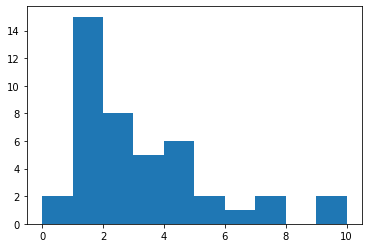


Summary Statistics
               0
count  43.000000
mean    2.767442
std     2.307722
min     0.000000
25%     1.000000
50%     2.000000
75%     4.000000
max    10.000000


AGAIN
Number of Attempts


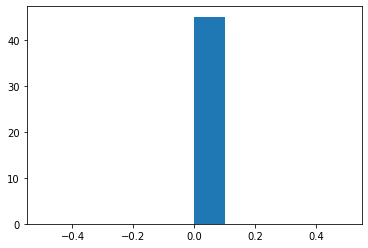


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


RESTRICT_DOMAIN
Number of Attempts


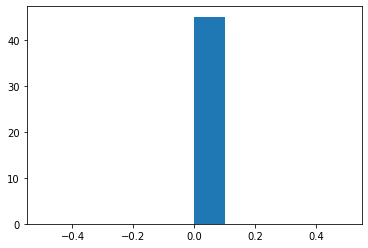


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


HAILSTONE
Number of Attempts


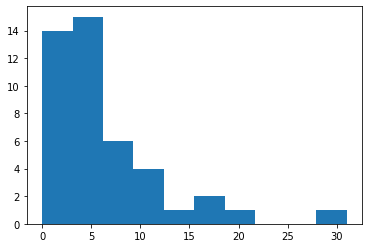


Summary Statistics
               0
count  44.000000
mean    6.477273
std     6.032812
min     0.000000
25%     3.000000
50%     5.000000
75%     8.250000
max    31.000000


RESTRICT_BOTH
Number of Attempts


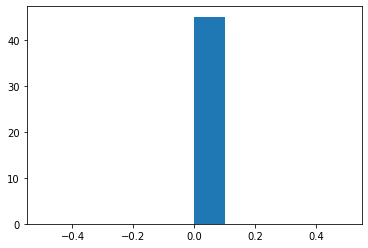


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


ACCUMULATE
Number of Attempts


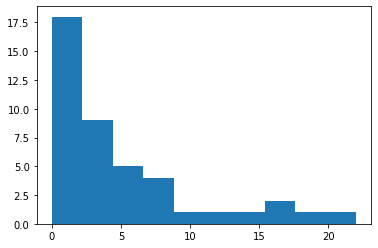


Summary Statistics
               0
count  43.000000
mean    5.162791
std     5.358261
min     0.000000
25%     2.000000
50%     3.000000
75%     6.500000
max    22.000000


FILTER_SEQUENCE
Number of Attempts


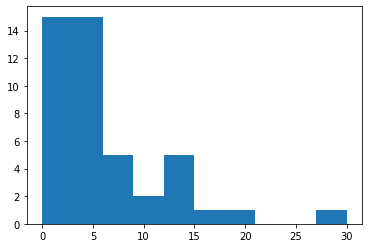


Summary Statistics
               0
count  45.000000
mean    5.755556
std     5.962594
min     0.000000
25%     1.000000
50%     4.000000
75%     8.000000
max    30.000000


PRODUCT_USING_ACCUMULATE
Number of Attempts


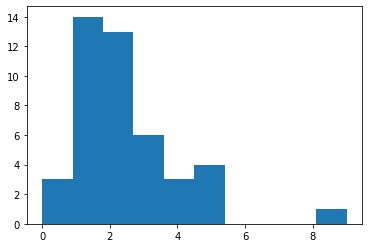


Summary Statistics
              0
count  44.00000
mean    2.25000
std     1.71349
min     0.00000
25%     1.00000
50%     2.00000
75%     3.00000
max     9.00000


RESTRICT_RANGE
Number of Attempts


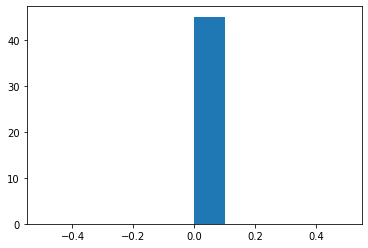


Summary Statistics
          0
count  45.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


COUNT_UNTIL_LARGER
Number of Attempts


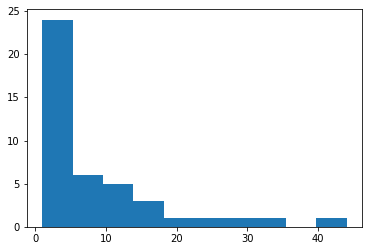


Summary Statistics
               0
count  43.000000
mean    8.069767
std     9.567792
min     1.000000
25%     2.000000
50%     4.000000
75%    11.000000
max    44.000000


PRODUCT
Number of Attempts


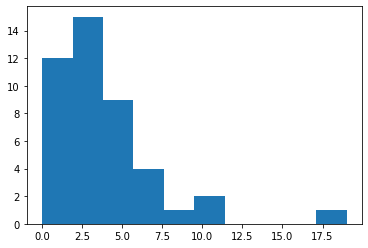


Summary Statistics
               0
count  44.000000
mean    3.704545
std     3.474690
min     0.000000
25%     1.000000
50%     3.000000
75%     5.000000
max    19.000000



In [14]:
num_attempts_graphs_using_df('hw02-sp22.csv', sp22_df_filters['no_languages_before'], 'no_languages_before')

## Lab 01

Generating num attempts for lab01-sp22.csv, using ['Veritasiness', 'sum_digits', 'Control', 'falling', 'digit_pos_match', 'debugging-quiz', 'begin', 'add_in_range', 'k_occurrence', 'double_eights']

VERITASINESS
Number of Attempts


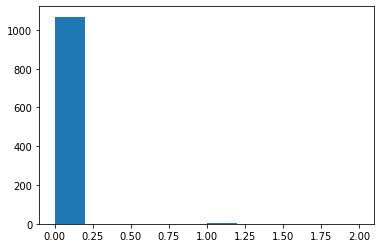


Summary Statistics
                 0
count  1072.000000
mean      0.004664
std       0.080710
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000


SUM_DIGITS
Number of Attempts


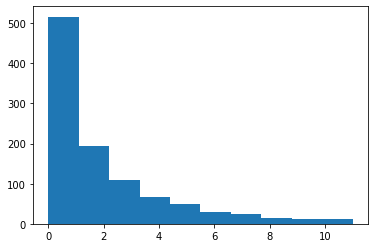


Summary Statistics
                 0
count  1030.000000
mean      2.264078
std       2.165228
min       0.000000
25%       1.000000
50%       1.000000
75%       3.000000
max      11.000000


CONTROL
Number of Attempts


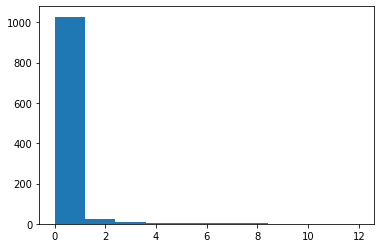


Summary Statistics
                 0
count  1072.000000
mean      0.197761
std       0.822237
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      12.000000


FALLING
Number of Attempts


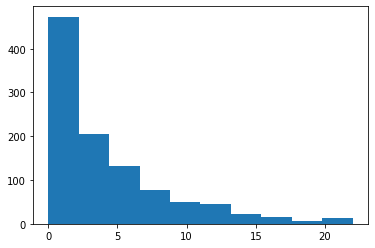


Summary Statistics
                 0
count  1042.000000
mean      4.316699
std       4.358512
min       0.000000
25%       1.000000
50%       3.000000
75%       6.000000
max      22.000000


DIGIT_POS_MATCH
Number of Attempts


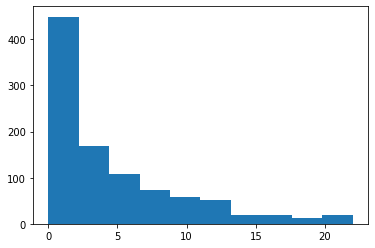


Summary Statistics
                0
count  980.000000
mean     4.782653
std      4.772742
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     22.000000


DEBUGGING-QUIZ
Number of Attempts


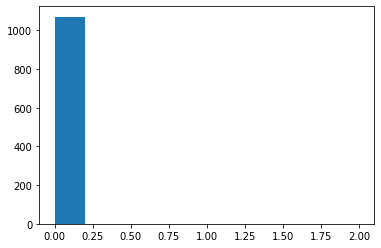


Summary Statistics
                 0
count  1072.000000
mean      0.002799
std       0.068269
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000


BEGIN
Number of Attempts


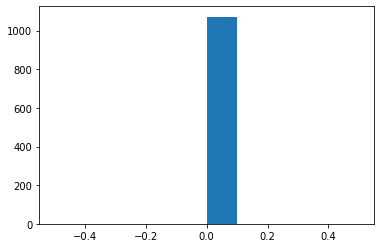


Summary Statistics
            0
count  1072.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0


ADD_IN_RANGE
Number of Attempts


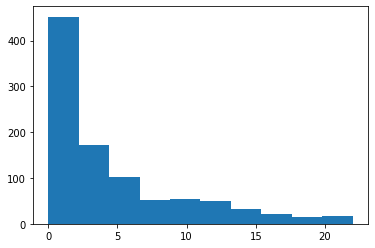


Summary Statistics
                0
count  969.000000
mean     4.884417
std      4.956532
min      0.000000
25%      1.000000
50%      3.000000
75%      6.000000
max     22.000000


K_OCCURRENCE
Number of Attempts


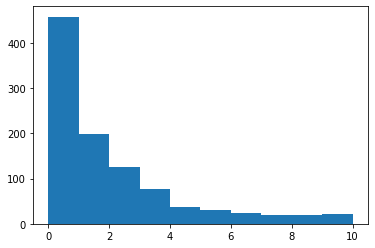


Summary Statistics
                 0
count  1013.000000
mean      1.610069
std       2.261767
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max      10.000000


DOUBLE_EIGHTS
Number of Attempts


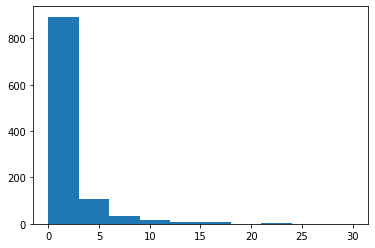


Summary Statistics
                 0
count  1072.000000
mean      1.322761
std       2.933169
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max      30.000000



In [15]:
# print(assignment_dfs[name].head())
num_attempts_graphs('lab01-sp22.csv')


Generating num attempts for lab01-sp22.csv, stratified by level, using ['Veritasiness', 'sum_digits', 'Control', 'falling', 'digit_pos_match', 'debugging-quiz', 'begin', 'add_in_range', 'k_occurrence', 'double_eights']
BEGINNER

VERITASINESS
Number of Attempts


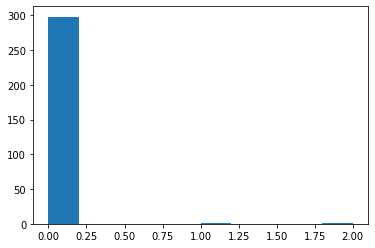


Summary Statistics
                0
count  300.000000
mean     0.010000
std      0.128927
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


SUM_DIGITS
Number of Attempts


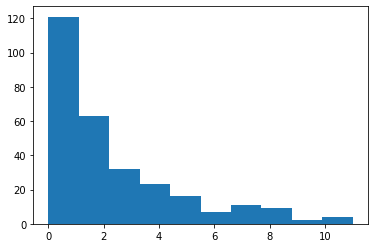


Summary Statistics
                0
count  288.000000
mean     2.555556
std      2.277837
min      0.000000
25%      1.000000
50%      2.000000
75%      3.250000
max     11.000000


CONTROL
Number of Attempts


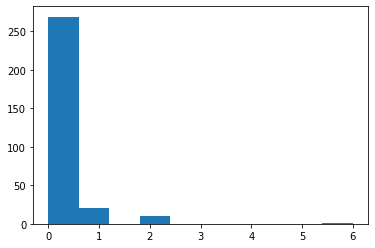


Summary Statistics
                0
count  300.000000
mean     0.153333
std      0.545418
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      6.000000


FALLING
Number of Attempts


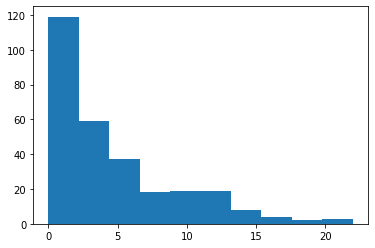


Summary Statistics
                0
count  288.000000
mean     4.684028
std      4.481571
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     22.000000


DIGIT_POS_MATCH
Number of Attempts


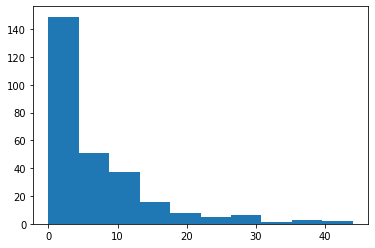


Summary Statistics
                0
count  278.000000
mean     6.931655
std      7.970093
min      0.000000
25%      1.000000
50%      4.000000
75%      9.000000
max     44.000000


DEBUGGING-QUIZ
Number of Attempts


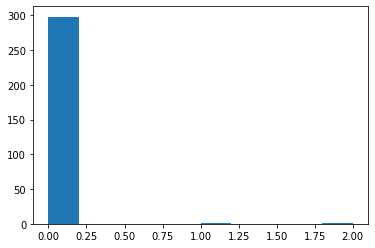


Summary Statistics
                0
count  300.000000
mean     0.010000
std      0.128927
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000


BEGIN
Number of Attempts


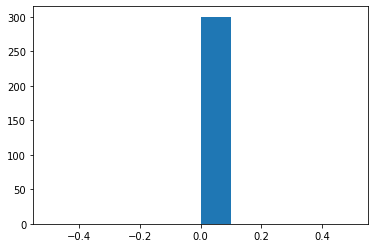


Summary Statistics
           0
count  300.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


ADD_IN_RANGE
Number of Attempts


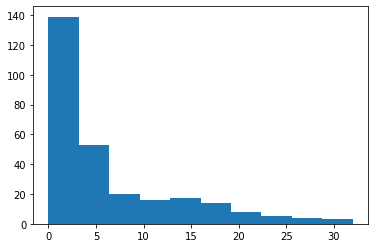


Summary Statistics
                0
count  279.000000
mean     6.444444
std      6.805332
min      0.000000
25%      2.000000
50%      4.000000
75%      9.000000
max     32.000000


K_OCCURRENCE
Number of Attempts


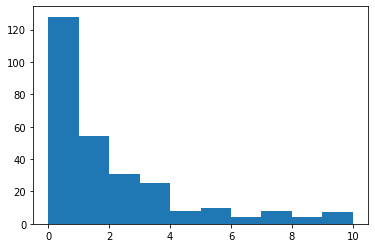


Summary Statistics
                0
count  279.000000
mean     1.616487
std      2.297922
min      0.000000
25%      0.000000
50%      1.000000
75%      2.000000
max     10.000000


DOUBLE_EIGHTS
Number of Attempts


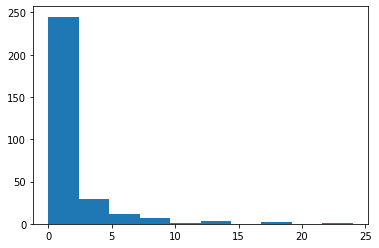


Summary Statistics
                0
count  300.000000
mean     1.326667
std      2.932910
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max     24.000000

INTERMEDIATE

VERITASINESS
Number of Attempts


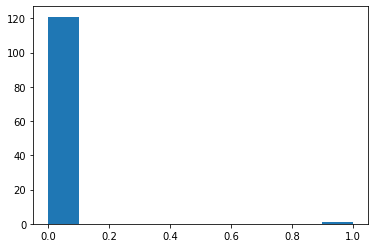


Summary Statistics
                0
count  122.000000
mean     0.008197
std      0.090536
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


SUM_DIGITS
Number of Attempts


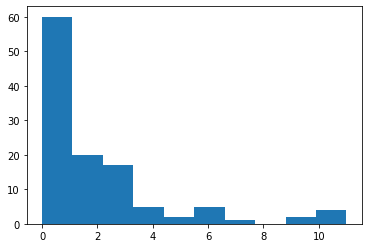


Summary Statistics
                0
count  116.000000
mean     2.327586
std      2.283308
min      0.000000
25%      1.000000
50%      1.000000
75%      3.000000
max     11.000000


CONTROL
Number of Attempts


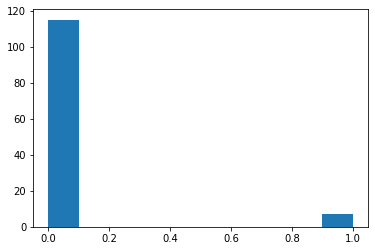


Summary Statistics
                0
count  122.000000
mean     0.057377
std      0.233521
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


FALLING
Number of Attempts


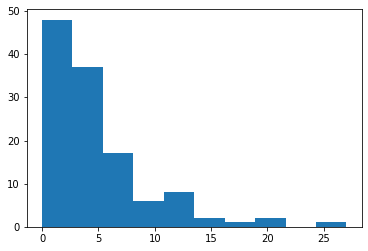


Summary Statistics
                0
count  122.000000
mean     4.868852
std      4.702647
min      0.000000
25%      1.250000
50%      3.500000
75%      7.000000
max     27.000000


DIGIT_POS_MATCH
Number of Attempts


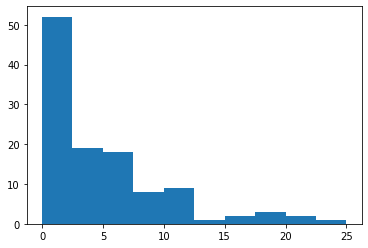


Summary Statistics
                0
count  115.000000
mean     5.008696
std      5.108465
min      0.000000
25%      1.000000
50%      3.000000
75%      7.000000
max     25.000000


DEBUGGING-QUIZ
Number of Attempts


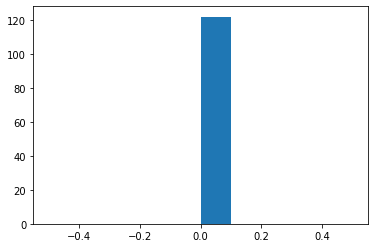


Summary Statistics
           0
count  122.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


BEGIN
Number of Attempts


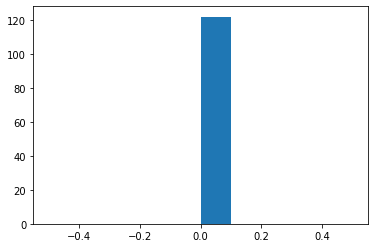


Summary Statistics
           0
count  122.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0


ADD_IN_RANGE
Number of Attempts


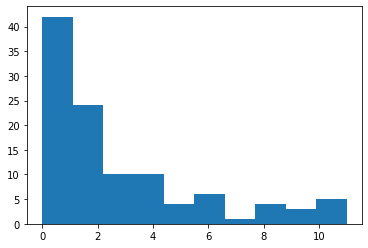


Summary Statistics
                0
count  109.000000
mean     3.045872
std      2.688747
min      0.000000
25%      1.000000
50%      2.000000
75%      4.000000
max     11.000000


K_OCCURRENCE
Number of Attempts


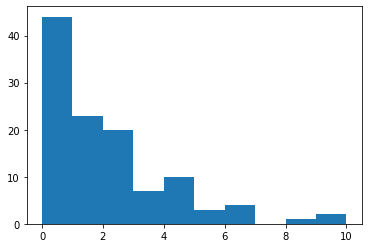


Summary Statistics
                0
count  114.000000
mean     1.675439
std      2.080230
min      0.000000
25%      0.000000
50%      1.000000
75%      2.000000
max     10.000000


DOUBLE_EIGHTS
Number of Attempts


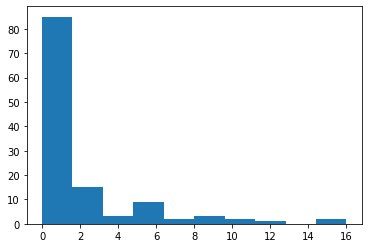


Summary Statistics
                0
count  122.000000
mean     1.811475
std      3.083767
min      0.000000
25%      0.000000
50%      0.000000
75%      2.000000
max     16.000000

ADVANCED

VERITASINESS
Number of Attempts


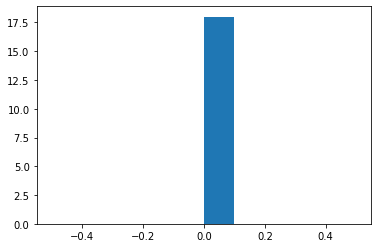


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


SUM_DIGITS
Number of Attempts


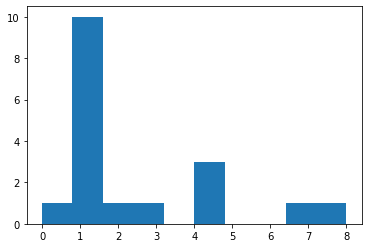


Summary Statistics
               0
count  18.000000
mean    2.333333
std     2.249183
min     0.000000
25%     1.000000
50%     1.000000
75%     3.750000
max     8.000000


CONTROL
Number of Attempts


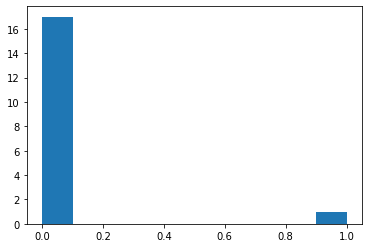


Summary Statistics
               0
count  18.000000
mean    0.055556
std     0.235702
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     1.000000


FALLING
Number of Attempts


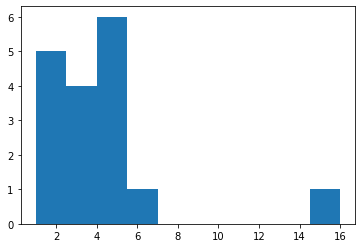


Summary Statistics
               0
count  17.000000
mean    4.058824
std     3.399827
min     1.000000
25%     2.000000
50%     3.000000
75%     5.000000
max    16.000000


DIGIT_POS_MATCH
Number of Attempts


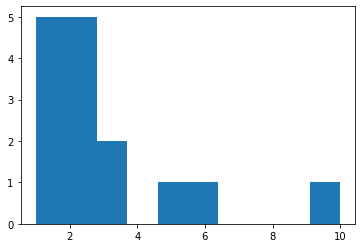


Summary Statistics
               0
count  15.000000
mean    2.800000
std     2.484236
min     1.000000
25%     1.000000
50%     2.000000
75%     3.000000
max    10.000000


DEBUGGING-QUIZ
Number of Attempts


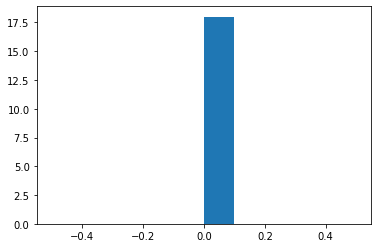


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


BEGIN
Number of Attempts


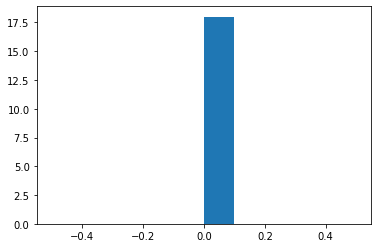


Summary Statistics
          0
count  18.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


ADD_IN_RANGE
Number of Attempts


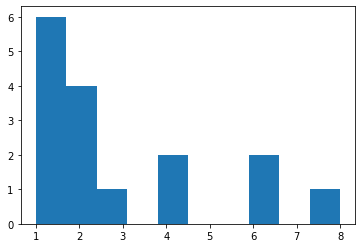


Summary Statistics
               0
count  16.000000
mean    2.812500
std     2.197536
min     1.000000
25%     1.000000
50%     2.000000
75%     4.000000
max     8.000000


K_OCCURRENCE
Number of Attempts


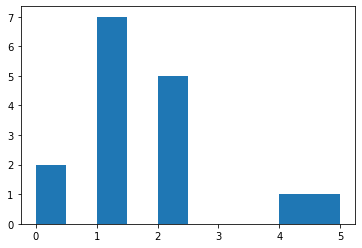


Summary Statistics
               0
count  16.000000
mean    1.625000
std     1.310216
min     0.000000
25%     1.000000
50%     1.000000
75%     2.000000
max     5.000000


DOUBLE_EIGHTS
Number of Attempts


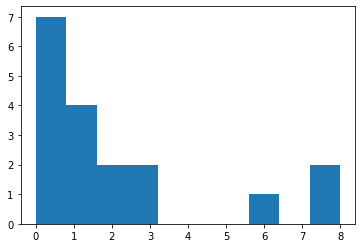


Summary Statistics
               0
count  18.000000
mean    2.000000
std     2.678894
min     0.000000
25%     0.000000
50%     1.000000
75%     2.750000
max     8.000000



In [16]:
num_attempts_graphs_by_level('lab01-sp22.csv')


Generating num attempts for lab01-sp22.csv, for people in NO_LANGUAGES_BEFORE, using ['Veritasiness', 'sum_digits', 'Control', 'falling', 'digit_pos_match', 'debugging-quiz', 'begin', 'add_in_range', 'k_occurrence', 'double_eights']

VERITASINESS
Number of Attempts


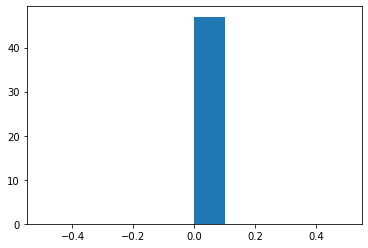


Summary Statistics
          0
count  47.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


SUM_DIGITS
Number of Attempts


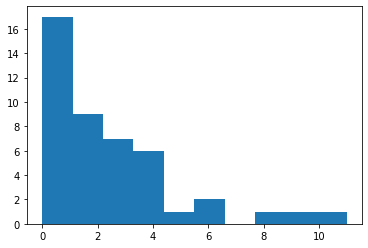


Summary Statistics
               0
count  45.000000
mean    2.622222
std     2.424205
min     0.000000
25%     1.000000
50%     2.000000
75%     4.000000
max    11.000000


CONTROL
Number of Attempts


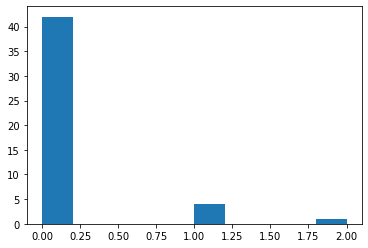


Summary Statistics
               0
count  47.000000
mean    0.127660
std     0.396562
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     2.000000


FALLING
Number of Attempts


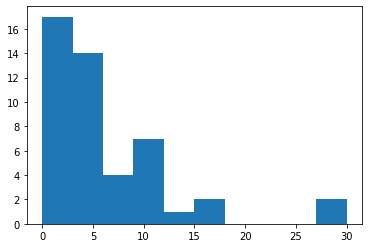


Summary Statistics
               0
count  47.000000
mean    5.914894
std     6.510292
min     0.000000
25%     2.000000
50%     4.000000
75%     8.500000
max    30.000000


DIGIT_POS_MATCH
Number of Attempts


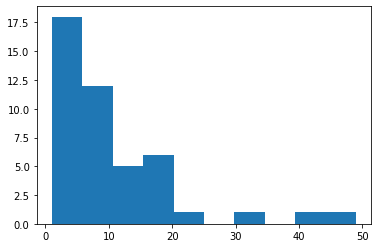


Summary Statistics
               0
count  45.000000
mean    9.800000
std    10.786355
min     1.000000
25%     1.000000
50%     7.000000
75%    14.000000
max    49.000000


DEBUGGING-QUIZ
Number of Attempts


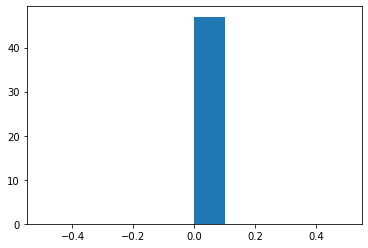


Summary Statistics
          0
count  47.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


BEGIN
Number of Attempts


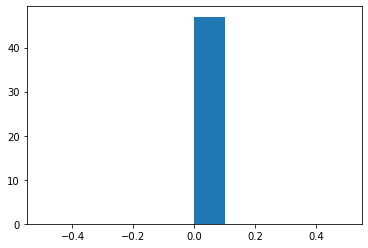


Summary Statistics
          0
count  47.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


ADD_IN_RANGE
Number of Attempts


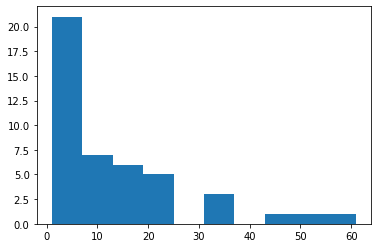


Summary Statistics
               0
count  45.000000
mean   12.711111
std    14.237630
min     1.000000
25%     3.000000
50%     7.000000
75%    16.000000
max    61.000000


K_OCCURRENCE
Number of Attempts


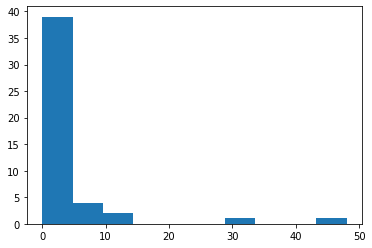


Summary Statistics
               0
count  47.000000
mean    3.255319
std     8.236895
min     0.000000
25%     0.000000
50%     0.000000
75%     2.500000
max    48.000000


DOUBLE_EIGHTS
Number of Attempts


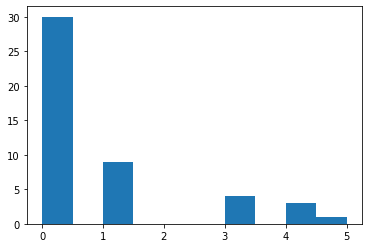


Summary Statistics
               0
count  47.000000
mean    0.808511
std     1.377431
min     0.000000
25%     0.000000
50%     0.000000
75%     1.000000
max     5.000000



In [17]:
num_attempts_graphs_using_df('lab01-sp22.csv', sp22_df_filters['no_languages_before'], 'no_languages_before')

In [18]:
num_attempts_graphs('lab02-sp21.csv')

TypeError: the JSON object must be str, bytes or bytearray, not int

In [ ]:
num_attempts_graphs_by_level('lab01.csv')

In [ ]:
name = 'lab01.csv'
load_assignment_df(name)
questions = get_questions(assignment_dfs[name])
questions = ['sum_digits']
num_attempts_per_question = generate_num_attempts(assignment_dfs[name], questions)
for q in questions:
    print()
    print(f"{q.upper()}")
    temp = np.array(list(num_attempts_per_question[q].values()))
#     print(len(temp))
    temp = reject_outliers(temp)
    temp_final = pd.DataFrame(list(temp))
    print()
    print("Summary Statistics")
    summary = temp_final.describe()
    print(summary)
    print()

# plot_num_attempts_per_question(num_attempts_per_question, questions)
# generate_num_attempts('lab01.csv', ['double_eights'])

In [ ]:
summary_list = summary.values.tolist()
summary_list = [str(s[0]) for s in summary_list]
print(','.join(summary_list))

In [ ]:
print_comma_separated_summary_statistics('lab01-sp22.csv', ['digit_pos_match', 'add_in_range', 'falling', 'sum_digits'], outlier_threshold=7)

In [ ]:
print_comma_separated_summary_statistics('lab01.csv', ['digit_pos_match', 'add_in_range', 'falling', 'sum_digits'])

In [ ]:
print_comma_separated_summary_statistics('lab02-sp22.csv', ['count_cond', 'hop','lambda_curry2','digit_index_factory'])

##  Lab 02

In [ ]:
# print(assignment_dfs[name].head())
num_attempts_graphs('lab02-sp22.csv')

In [ ]:
num_attempts_graphs_by_level('lab02-sp22.csv')

In [ ]:
num_attempts_graphs('lab02-sp21.csv')

In [ ]:
num_attempts_graphs_by_level('lab02.csv')

In [ ]:
print_comma_separated_summary_statistics('lab02-sp22.csv', ['hop', 'digit_index_factory', 'lambda_curry2', 'count_cond'])

In [ ]:
print_comma_separated_summary_statistics('lab02.csv', ['lambda_curry2', 'count_cond'])

## Lab 04

In [ ]:
# print(assignment_dfs[name].head())
num_attempts_graphs('lab04-sp22.csv')

In [ ]:
num_attempts_graphs_by_level('lab04-sp22.csv')

In [ ]:
num_attempts_graphs('lab04-sp21.csv')

In [ ]:
num_attempts_graphs_by_level('lab04.csv')

## Lab 05

In [ ]:
# print(assignment_dfs[name].head())
num_attempts_graphs('lab05-sp22.csv')

In [ ]:
num_attempts_graphs_by_level('lab05-sp22.csv')

In [ ]:
num_attempts_graphs('lab05.csv')

In [ ]:
num_attempts_graphs_by_level('lab05.csv')

## Lab 06

In [ ]:
# print(assignment_dfs[name].head())
num_attempts_graphs('lab06-sp22.csv')

In [ ]:
num_attempts_graphs_by_level('lab06-sp22.csv')

In [ ]:
num_attempts_graphs('lab06.csv')

In [ ]:
num_attempts_graphs_by_level('lab06.csv')

## HW 01

In [ ]:
# print(assignment_dfs[name].head())
num_attempts_graphs('hw01-sp22.csv')

In [ ]:
num_attempts_graphs_by_level('hw01-sp22.csv')

In [ ]:
num_attempts_graphs_using_df('hw01-sp22.csv', sp22_df_filters['no_languages_before'], 'no_languages_before')

In [ ]:
num_attempts_graphs('hw01.csv')

In [ ]:
num_attempts_graphs_by_level('hw01.csv')

In [ ]:
num_attempts_graphs_using_df('hw01.csv', sp21_df_filters['no_languages_before'], 'no_languages_before')

# HW 02

In [ ]:
num_attempts_graphs('hw02-sp22.csv')

In [ ]:
num_attempts_graphs_by_level('hw02-sp22.csv')

In [ ]:
num_attempts_graphs_using_df('hw02-sp22.csv', sp22_df_filters['no_languages_before'], 'no_languages_before')

In [ ]:
num_attempts_graphs('hw02.csv')

In [ ]:
num_attempts_graphs_by_level('hw02.csv')

In [ ]:
num_attempts_graphs_using_df('hw02.csv', sp21_df_filters['no_languages_before'], 'no_languages_before')

# HW 03

In [ ]:
num_attempts_graphs('hw03-sp22.csv')

In [ ]:
num_attempts_graphs_by_level('hw03-sp22.csv')

In [ ]:
num_attempts_graphs_using_df('hw03-sp22.csv', sp22_df_filters['no_languages_before'], 'no_languages_before')

In [ ]:
num_attempts_graphs('hw03.csv')

In [ ]:
num_attempts_graphs_by_level('hw03.csv')

In [ ]:
num_attempts_graphs_using_df('hw03.csv', sp21_df_filters['no_languages_before'], 'no_languages_before')

# HW 04

In [ ]:
num_attempts_graphs('hw04-sp22.csv')

In [ ]:
num_attempts_graphs_by_level('hw04-sp22.csv')

In [ ]:
num_attempts_graphs('hw04.csv')

In [ ]:
num_attempts_graphs_by_level('hw04.csv')

# HW 05

In [ ]:
num_attempts_graphs('hw05-sp22.csv')

In [ ]:
num_attempts_graphs_by_level('hw05-sp22.csv')

In [ ]:
num_attempts_graphs('hw05.csv')

In [ ]:
num_attempts_graphs_by_level('hw05.csv')

# Summary Statistics for spreadsheet

In [ ]:
print_comma_separated_summary_statistics('lab07-sp21.csv', ['cumulative_mul'], use_iqr=True)

In [ ]:
print_comma_separated_summary_statistics('hw01.csv', ['k_in_num', 'two_of_three', 'a_plus_abs_b', 'largest_factor', 'with_if_statement','hailstone'], use_iqr=True)

In [ ]:
print_comma_separated_summary_statistics('hw02-sp22.csv', ['product', 'summation_using_accumulate', 'hailstone','count_until_larger', 'product_using_accumulate', 'filter_sequence', 'accumulate', 'make_repeater'], use_iqr=True)

In [ ]:
print_comma_separated_summary_statistics('hw02.csv', ['product', 'summation_using_accumulate', 'hailstone','count_until_larger', 'product_using_accumulate', 'filter_sequence', 'accumulate', 'make_repeater'], use_iqr=True)

In [ ]:
print_comma_separated_summary_statistics('hw03-sp22.csv', ['has_subseq', 'count_coins', 'pingpong', 'num_eights', 'neighbor_digits', 'missing_digits'], use_iqr=True)

In [ ]:
print_comma_separated_summary_statistics('hw03.csv', ['has_subseq', 'count_coins', 'pingpong', 'num_eights', 'neighbor_digits', 'missing_digits'], use_iqr=True)

In [ ]:
print_comma_separated_summary_statistics('hw04-sp22.csv', [
     'remove_odd_indices', 'SmartFridge', 'merge', 'VendingMachine', 'Mint'
], use_iqr=True)

In [ ]:
print_comma_separated_summary_statistics('hw04.csv', [
     'balanced', 'preorder', 'total_weight', 'totals_tree', 'has_path', 'replace_thor_at_leaf'
], use_iqr=True)

In [ ]:
print_comma_separated_summary_statistics('hw05-sp22.csv', [
     'duplicate_link', 'flatten_link', 'has_path', 'deep_map_mut', 'chain'
], use_iqr=True)

In [ ]:
print_comma_separated_summary_statistics('hw05.csv', [
     'VendingMachine', 'store_digits', 'path_yielder'
], use_iqr=True)

# Time Spent

In [ ]:
def bucket_diffs(timestamps):
    num_buckets = 0

    if len(timestamps) <= 1:
        return None
    
    result, timestamps = [], list(timestamps)
    
    initial_timestamp = parser.parse(timestamps[0])
    
    for i in range(len(timestamps) - 1):
        current_timestamp = parser.parse(timestamps[i])
        next_timestamp = parser.parse(timestamps[i + 1])
        time_temp = (next_timestamp - current_timestamp).total_seconds() / 3600
        
        
        if time_temp >= 1.2:
            num_buckets += 1
            temp_time_to_add = (current_timestamp - initial_timestamp).total_seconds() / 3600
            
            initial_timestamp = next_timestamp
            result.append(temp_time_to_add)
    
    if parser.parse(timestamps[-1]) != initial_timestamp:
        time_temp = (parser.parse(timestamps[-1]) - initial_timestamp).total_seconds() / 3600
        result.append(time_temp)
    
    return result
            

In [ ]:
def keep_question(data, problem):

    
    if type(data) is str:
        return False
    
    
    data_keys = data.keys()

    
    if "question" in data_keys:
        if data["question"][0] == problem:
            return True
    else:
        return False
    

In [ ]:
def generate_total_time_spent(name):
    load_assignment_df(name)
    buckets_all_students = assignment_dfs[name].groupby('student_id')['timestamp'].agg(bucket_diffs)
    
    bucket_times = [sum(bucket_list) for bucket_list in list(buckets_all_students) if bucket_list != None]
    
    plt.hist(bucket_times)
    
    print(pd.DataFrame(bucket_times).describe())

def generate_total_time_spent_problem(name, problem):
    load_assignment_df(name)
    
    # start code temp
    
    assignment_df_temp = assignment_dfs[name].copy()
    
    
    assignment_df_temp = assignment_df_temp[assignment_df_temp['message_type'] == 'analytics']
    
    assignment_df_temp['data'] = assignment_df_temp['data'].map(lambda s: json.loads(s))
    
    data_list = list(assignment_df_temp['data'])
    
    
    data_list_bool = [keep_question(temp_dict, problem) for temp_dict in data_list]
    
    
    assignment_df_temp['data_list_bool'] = data_list_bool 
    
    assignment_df_temp = assignment_df_temp[assignment_df_temp['data_list_bool'] == True]
    
    
    assignment_df_temp = assignment_df_temp.drop(['data_list_bool'], axis=1)
    
    assignment_df_temp.head()
    
    # end codee temp
    buckets_all_students = assignment_df_temp.groupby('student_id')['timestamp'].agg(bucket_diffs)
    
    bucket_times = [sum(bucket_list) for bucket_list in list(buckets_all_students) if bucket_list != None]
    
    plt.hist(bucket_times)
    
    
    print(pd.DataFrame(bucket_times).describe())



In [ ]:
lab2_temp = load_assignment_df('lab05.csv')

lab2_temp

# Lab 01

In [ ]:
generate_total_time_spent_problem('lab07-sp22.csv', 'label_multiplier')

In [ ]:
generate_total_time_spent('lab01-sp22.csv')

# Lab 02

In [ ]:
generate_total_time_spent('lab02-sp22.csv')

In [ ]:
generate_total_time_spent('lab02.csv')

# Lab 04

In [ ]:
generate_total_time_spent('lab04-sp22.csv')

In [ ]:
generate_total_time_spent('lab04.csv')

# Lab 05

In [ ]:
generate_total_time_spent('lab05-sp22.csv')

In [ ]:
generate_total_time_spent('lab05.csv')

# Lab 06

In [ ]:
generate_total_time_spent('lab06-sp22.csv')

In [ ]:
generate_total_time_spent('lab06.csv')

# Lab 07

In [ ]:
generate_total_time_spent('lab07-sp22.csv') # RERUN then remove this comment

In [ ]:
generate_total_time_spent('lab07.csv')

# HW 01

In [ ]:
generate_total_time_spent('hw01-sp22.csv')

In [ ]:
generate_total_time_spent('hw01.csv')

# HW 02

In [ ]:
generate_total_time_spent('hw02-sp22.csv')

In [ ]:
generate_total_time_spent('hw02.csv')

# HW 03

In [ ]:
generate_total_time_spent('hw03-sp22.csv')

In [ ]:
generate_total_time_spent('hw03.csv')

# HW 04

In [ ]:
generate_total_time_spent('hw04-sp22.csv')

In [ ]:
generate_total_time_spent('hw04.csv')

# Mann-Whitney test

# question --> pingpong

In [ ]:
%pip install scipy

In [19]:
from scipy.stats import mannwhitneyu

In [20]:
def getAttemptsArray(name, questions, outlier_threshold=10, use_iqr=False):
    load_assignment_df(name)
    num_attempts_per_question = generate_num_attempts(assignment_dfs[name], questions)
    summaries = {}
    for q in questions:
        temp = np.array(list(num_attempts_per_question[q].values()))
    #     print(len(temp))
        if use_iqr:
            temp = reject_outliers_using_iqr(temp)
        else:
            temp = reject_outliers(temp, outlier_threshold)
        temp_final = pd.DataFrame(list(temp))
        summary = temp_final.describe()
        summaries[q] = summary
        
    return temp

In [25]:
sp21_group = getAttemptsArray('hw02.csv', ['summation_using_accumulate'])
sp22_group = getAttemptsArray('hw02-sp22.csv', ['summation_using_accumulate'])

sp22_group

array([1, 5, 2, ..., 1, 0, 0])

In [26]:
U1, p = mannwhitneyu(sp21_group, sp22_group) 

In [27]:
print(U1)

384066.0


In [28]:
print(p)

4.280727011032943e-28
